In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:

schools_raw = pd.read_csv('schools_data_BACKUP.csv')

In [11]:
schools_raw.head(2)

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,longitude,rating,rating_year,distance
0,3605242,The Karafin School,private,"9,10,11,12",h,Mount Kisco,NY,10549,NaN,41.204262,-73.727074,NaN,NaN,0.34826
1,3607320,Talmud Torah Bais Yechiel-Nitra,private,"PK,KG,1,2,3,4,5,6,7,8,9","p,e,m",Mount Kisco,NY,11211,NaN,41.204262,-73.727074,NaN,NaN,0.34826


In [8]:

demog_raw = pd.read_csv('demographics_mstr_BACKUP.csv')

In [12]:
demog_raw.head(2)

,enrollment,percent-reduced-lunch,percent-disadvantaged,percent-limited-english,average-salary,student-teacher-ratio,student-counselor-ratio,percentage-female,teachers-experience,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,44.4444,NaN,NaN,3605242,43.0556,34.7222,19.4444,2.77778,0.0,0.0,0.0,NaN
1,231.0,NaN,NaN,NaN,NaN,NaN,NaN,40.2597,NaN,NaN,3607320,0.0000,100.0000,0.0000,0.00000,0.0,0.0,0.0,NaN


In [14]:
# merge right on 'id', left on 'Universal_ID'

df = schools_raw.merge(demog_raw, left_on='id', right_on='Universal_ID', how='outer')

In [15]:
# inspect merge results

df.head()

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
0,3605242,The Karafin School,private,"9,10,11,12",h,Mount Kisco,NY,10549,NaN,41.204262,...,NaN,3605242.0,43.055600,34.722200,19.444400,2.77778,0.0,0.000000,0.000000,NaN
1,3607320,Talmud Torah Bais Yechiel-Nitra,private,"PK,KG,1,2,3,4,5,6,7,8,9","p,e,m",Mount Kisco,NY,11211,NaN,41.204262,...,NaN,3607320.0,0.000000,100.000000,0.000000,0.00000,0.0,0.000000,0.000000,NaN
2,3601714,Mount Kisco Elementary School,public,"KG,1,2,3,4,5",e,Mount Kisco,NY,10549,Bedford Central School District,41.202629,...,100.0,3601714.0,66.276803,25.146198,2.534113,NaN,0.0,3.313840,0.000000,2.729044
3,3601716,West Patent Elementary School,public,"KG,1,2,3,4,5,UG",e,Bedford Hills,NY,10507,Bedford Central School District,41.214245,...,100.0,3601716.0,31.023102,54.785478,2.640264,NaN,0.0,4.620462,0.330033,6.600660
4,3615676,The Country Childrens Center,private,"PK,KG","p,e",Bedford Hills,NY,10507,NaN,41.234066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# look for big patterns

df.describe()

,id,zip_code,latitude,longitude,rating,rating_year,distance,enrollment,percent-reduced-lunch,percent-disadvantaged,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander
count,2.439000e+03,2439.000000,2439.000000,2439.000000,1358.000000,1358.000000,2439.000000,1597.000000,1236.000000,0.0,...,1207.000000,1.598000e+03,1598.000000,1597.000000,1589.000000,336.000000,1492.000000,1577.000000,1472.000000,1256.000000
mean,3.121916e+06,9471.830668,41.014540,-73.822946,5.698085,2020.159057,22.675495,491.680651,53.025119,NaN,...,97.229572,3.558905e+06,37.447865,34.984417,16.978432,8.620144,0.306179,2.377534,0.419495,7.474823
std,9.911636e+05,1762.954291,0.195947,0.248301,2.392295,0.365864,6.135103,381.706007,35.478441,NaN,...,10.157801,8.596574e+04,28.045081,33.319836,19.935998,16.762758,0.981407,4.424197,1.048054,10.330613
min,9.000030e+05,6468.000000,40.771336,-74.294998,1.000000,2020.000000,0.348260,0.000000,0.000000,NaN,...,11.111111,3.400031e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.402210e+06,7605.000000,40.854503,-73.978736,4.000000,2020.000000,19.161671,272.000000,15.147420,NaN,...,100.000000,3.600484e+06,11.074229,2.191200,2.000000,0.000000,0.000000,0.218340,0.000000,1.183901
50%,3.602566e+06,10457.000000,40.943081,-73.890633,6.000000,2020.000000,24.818930,422.000000,60.674377,NaN,...,100.000000,3.603172e+06,32.363706,25.000000,8.890000,2.820789,0.000000,1.049618,0.146960,3.517653
75%,3.607492e+06,10583.000000,41.131378,-73.730396,8.000000,2020.000000,27.360833,605.000000,87.421413,NaN,...,100.000000,3.607202e+06,62.782643,66.666651,25.714300,9.143765,0.312014,3.183023,0.518487,8.916137
max,3.618423e+06,12590.000000,41.606472,-73.145691,10.000000,2021.000000,29.999681,4845.000000,100.000000,NaN,...,100.000000,3.618421e+06,100.000000,100.000000,100.000000,100.000000,20.161300,100.000000,29.951690,67.857142


Text(0.5, 1.0, 'Distribution of School Ratings')

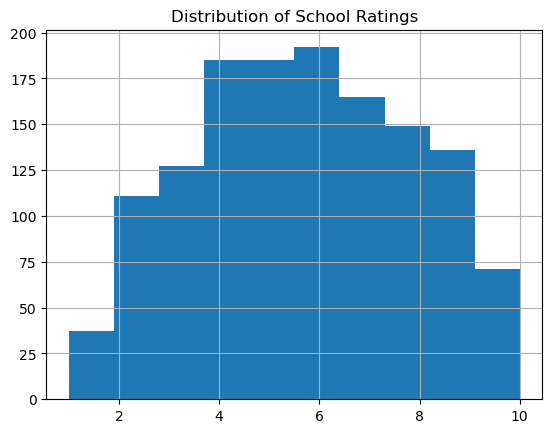

In [21]:


df['rating'].hist()
plt.title('Distribution of School Ratings')

In [23]:
# check for duplicates in main identifier

df[df.duplicated(subset='id', keep=False)]

,id,name,type,level,level_codes,city,state,zip_code,district,latitude,...,percentage-certified,Universal_ID,Hispanic,White,African American,Asian,Native Hawaiian or Other Pacific Islander,Two or more races,Native American,Asian or Pacific Islander


In [24]:


df['district'].value_counts()

New York City Geographic District #10                 85
New York City Geographic District # 9                 69
New York City Geographic District #11                 62
New York City Geographic District # 8                 56
New York City Geographic District #12                 50
                                                      ..
Grand Concourse Academy Charter School                 1
Bronx Preparatory Charter School                       1
Urban Assembly Charter School for Computer Science     1
Icahn Charter School 1                                 1
New York City Geographic District #26                  1
Name: district, Length: 302, dtype: int64

In [29]:
# ratings by district

(
    df.groupby(by='district')['rating']
    .agg(mean='mean').sort_values(by='mean', ascending=False).head(50)
)


,mean
district,
Academic Leadership Charter School,10.000000
Oradell Public School District,10.000000
Englewood Cliffs School District,10.000000
Icahn Charter School 3,10.000000
Bronx Charter School for Excellence 2,10.000000
Allendale Public School District,10.000000
New York City Geographic District #26,10.000000
Success Academy Charter School-Bronx 2,10.000000
Northern Valley Regional High School District,10.000000


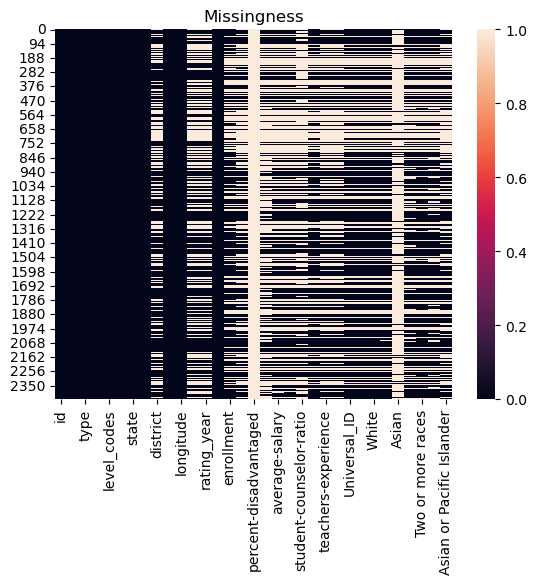

In [40]:
# missingness

sns.heatmap(df.isnull())
plt.title('Missingness')
plt.show()

In [55]:
# percent null

round(df.isnull().sum()/len(df),2)*100

id                                             0.0
name                                           0.0
type                                           0.0
level                                          0.0
level_codes                                    0.0
city                                           0.0
state                                          0.0
zip_code                                       0.0
district                                      39.0
latitude                                       0.0
longitude                                      0.0
rating                                        44.0
rating_year                                   44.0
distance                                       0.0
enrollment                                    35.0
percent-reduced-lunch                         49.0
percent-disadvantaged                        100.0
percent-limited-english                       61.0
average-salary                                51.0
student-teacher-ratio          

In [89]:
# drop 100% null column

df = df.drop(columns=['percent-disadvantaged'])

In [90]:
# cross join on district to fill average salary?

unique_salary = (
    df.groupby(by='district')['average-salary']
    .agg(nunique='nunique').sort_values(by='nunique')['nunique'].eq(1)
)

unique_salary

district
Abbott Union Free School District                                False
New York State Office Mental Health (Office of Mental Health)    False
New Milford School District                                      False
New Fairfield School District                                    False
New Canaan School District                                       False
                                                                 ...  
New York City Geographic District #12                            False
New York City Geographic District # 8                            False
New York City Geographic District #11                            False
New York City Geographic District # 9                            False
New York City Geographic District #10                            False
Name: nunique, Length: 302, dtype: bool

In [88]:
#inspect salaries per district
df.dropna(subset='district').set_index(['district','average-salary']).head(50).sort_index()

id  \
district                                     average-salary            
Bedford Central School District              102982.15       3601714   
                                             109263.82       3601711   
                                             115800.92       3601715   
                                             120435.92       3601712   
                                             122886.80       3601716   
                                             125763.90       3601717   
                                             131310.23       3601713   
Briarcliff Manor Union Free School District  90146.59        3600319   
                                             99260.33        3600320   
                                             99858.19        3600318   
Byram Hills Central School District          107665.32       3600421   
                                             122366.43       3600424   
                                             131504.15       3600423   
                                             157789.81       3600422   
Chappaqua Central School District            100143.00       3607765   
                                             107688.06       3600517   
                                             110238.91       3600513   
                                             117754.02       3600514   
                                             119007.73       3600516   
                                             127063.50       3600515   
Croton-Harmon Union Free School District     96598.71        3600660   
                                             103132.01       3600661   
Greenwich School District                    NaN              900338   
Katonah-Lewisboro Union Free School District 121311.87       3601326   
                                             122517.48       3601323   
                                             126020.99       3601324   
                                             134218.72       3601325   
Mount Pleasant Central School District       82434.12        3601742   
                                             92817.49        3601739   
                                             93150.63        3601741   
                                             95627.99        3601740   
Ossining Union Free School District          93835.05        3603147   
                                             95595.39        3603145   
                                             106032.57       3603149   
                                             108896.04       3603148   
                                             114258.90       3603146   
                                             116509.85       3606439   
Pleasantville Union Free School District     94815.51        3603282   
                                             94846.36        3603281   
                                             101148.64       3603280   
Somers Central School District               97955.44        3603674   
                                             106319.62       3603672   
                                             112848.10       3603671   
Valhalla Union Free School District          0.00            3603905   
                                             5108.33         3603907   
                                             48000.00        3603908   
Yorktown Central School District             105544.45       3604188   
                                             108148.05       3604185   
                                             116278.91       3604187   
                                             116979.75       3604189   

                                                                                          name  \
district                                     average-salary                                      
Bedford Central School District              102982.15           Mount Kisco Elementary School   
                           

In [105]:
# observe asian and 'Asian or Pacific Islander'

df[['Asian', 'Asian or Pacific Islander']] # appears to be an or-condition

bad_overlap = (df['Asian'].notna() & df['Asian or Pacific Islander'].notna())

assert not bad_overlap.any(), 'Columns not mergable'

In [109]:
# merge asian and asian or pacific islander

df['Asian_combo'] = (
    df['Asian'].fillna(df['Asian or Pacific Islander'])
)

# drop original cols

df = df.drop(columns=['Asian', 'Asian or Pacific Islander'])


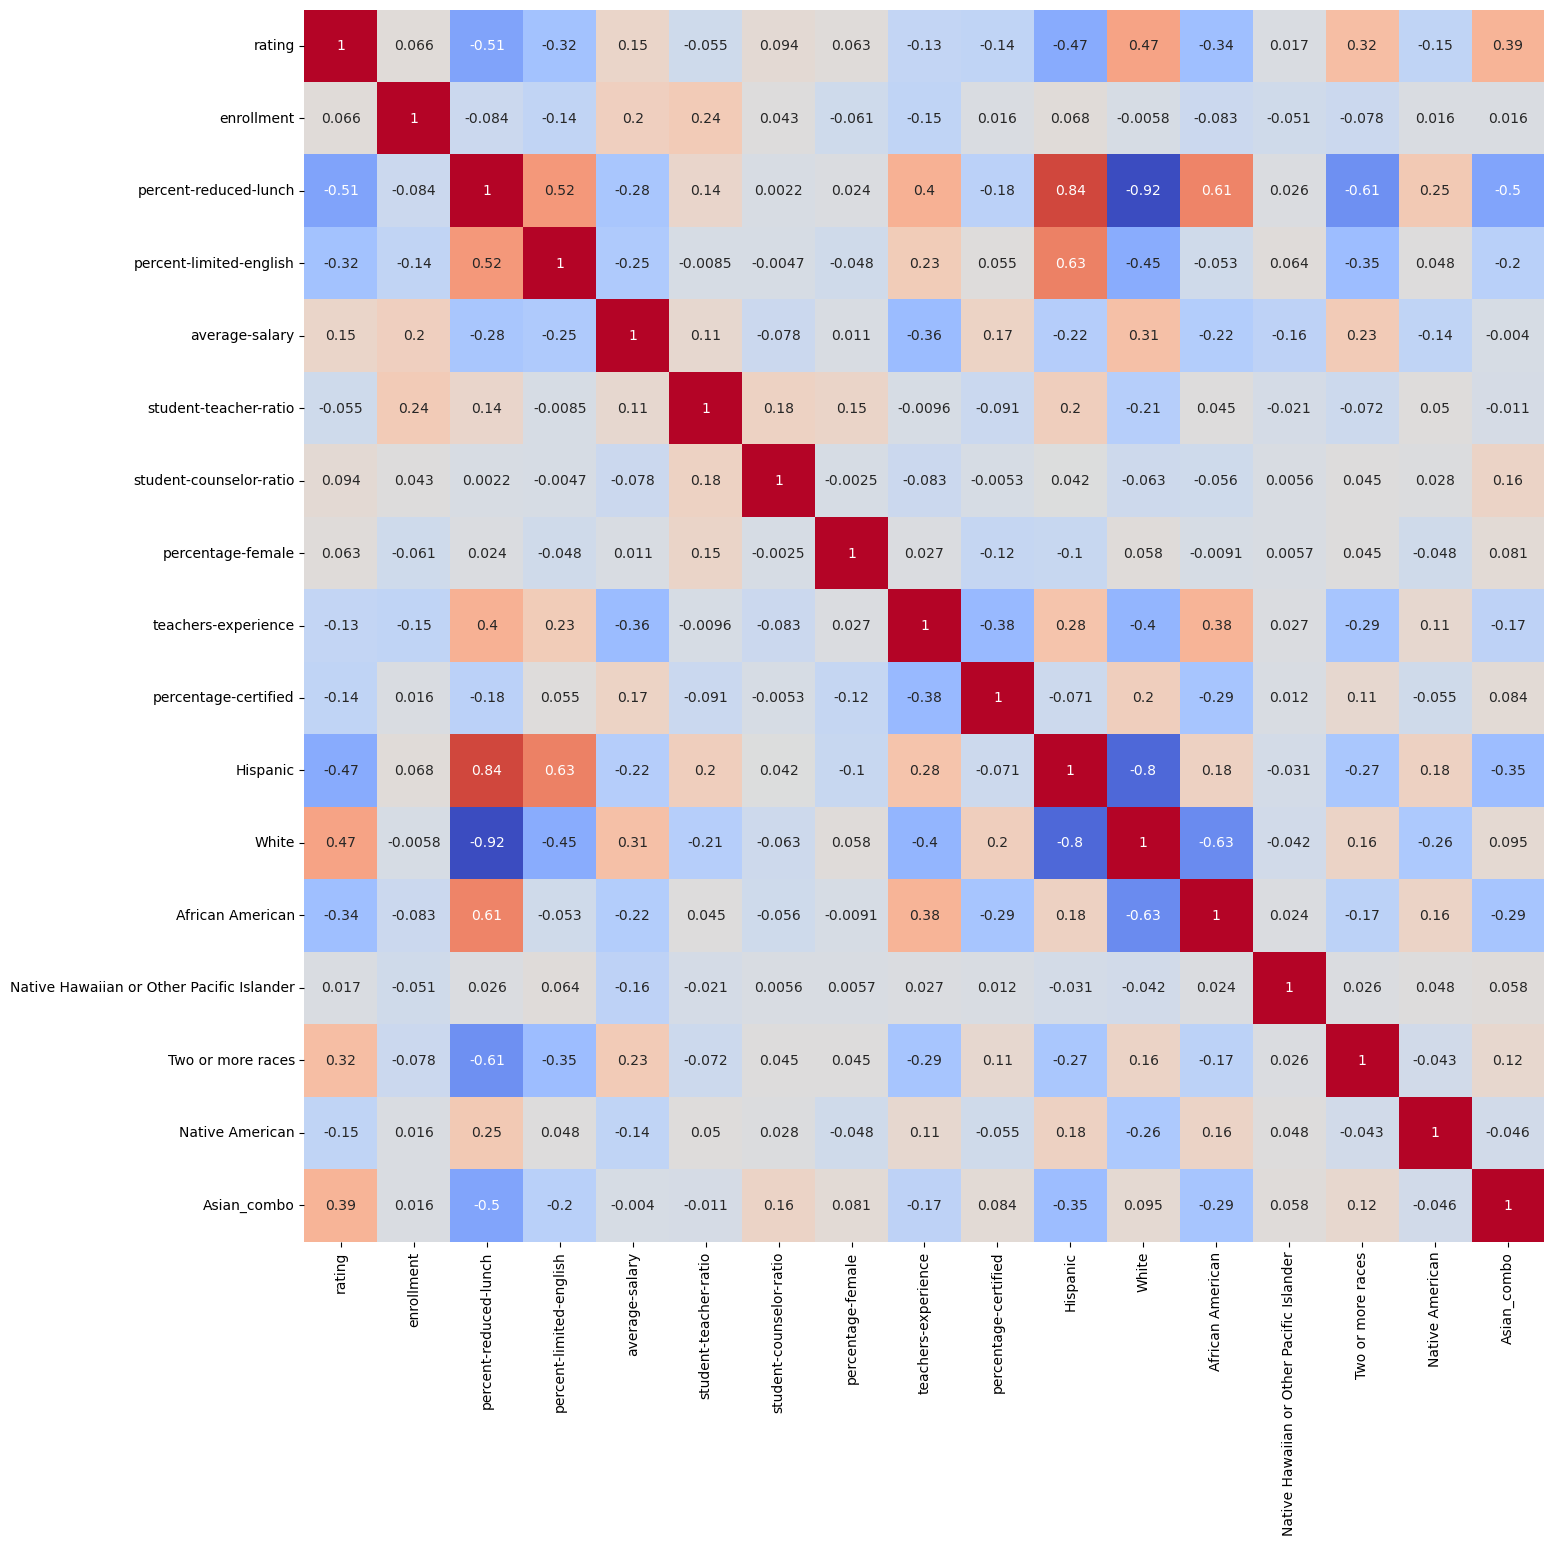

In [110]:
# inspect feature correlations with heatmap

fig, ax = plt.subplots(figsize=(16,16))
corr = df.drop(
    columns=['Universal_ID','id','zip_code','distance', 'rating_year','latitude', 'longitude']
).select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cbar=False, cmap='coolwarm')
plt.show()

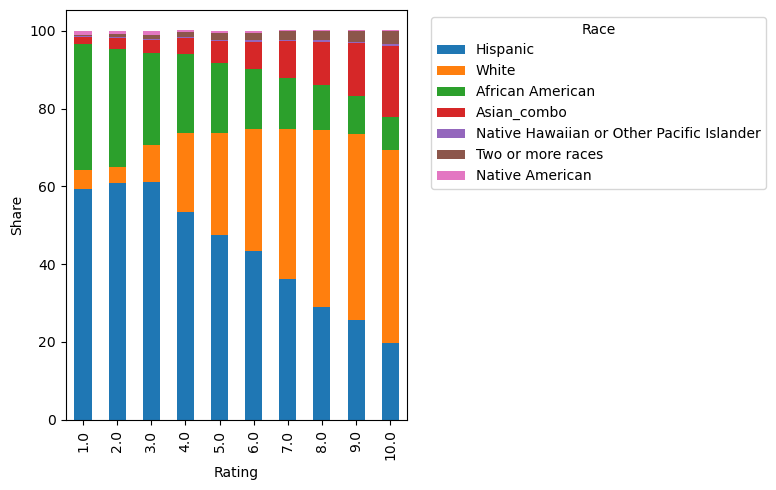

In [119]:
# stacked bar chart

df_rating = df.dropna(subset='rating')

demog_race = ['Hispanic', 'White','African American', 'Asian_combo', 
              'Native Hawaiian or Other Pacific Islander', 'Two or more races',
              'Native American']

plot_df = (
    df_rating
    .groupby('rating')[demog_race]
    .mean()     # or .sum(), depending on meaning
    .sort_index()
)

ax = plot_df.plot(kind='bar', stacked=True, figsize=(8, 5))
ax.set_ylabel('Share')
ax.set_xlabel('Rating')
ax.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()



Index(['enrollment', 'percent-reduced-lunch', 'percent-disadvantaged',
       'percent-limited-english', 'average-salary', 'student-teacher-ratio',
       'student-counselor-ratio', 'percentage-female', 'teachers-experience',
       'percentage-certified', 'Universal_ID', 'Hispanic', 'White',
       'African American', 'Asian',
       'Native Hawaiian or Other Pacific Islander', 'Two or more races',
       'Native American', 'Asian or Pacific Islander'],
      dtype='object')